In [3]:
import pandas as pd
import numpy as np
from tensorflow import keras
from keras.models import Sequential
from keras.layers import LSTM, Dense

In [4]:
import yfinance as yf

# Define the ticker symbol and date range
ticker = "GOOGL"
start_date = "2020-01-01"
end_date = "2023-01-01"

# Download the data
data = yf.download(ticker, start=start_date, end=end_date)

# Print the first 5 rows of the data
print(data.head())

YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  1 of 1 completed

Price           Close       High        Low       Open    Volume
Ticker          GOOGL      GOOGL      GOOGL      GOOGL     GOOGL
Date                                                            
2020-01-02  68.108376  68.108376  67.004158  67.099702  27278000
2020-01-03  67.752068  68.360661  67.045447  67.079289  23408000
2020-01-06  69.557945  69.583321  67.228582  67.259926  46768000
2020-01-07  69.423592  69.841098  69.246938  69.689821  34330000
2020-01-08  69.917725  70.256604  69.300178  69.409154  35314000


In [5]:
from sklearn.preprocessing import MinMaxScaler

# Select the 'Close' price column
dataset = data[['Close']].values

# Scale the data
scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(dataset)

# Split into train and test sets
train_size = int(len(dataset) * 0.8)
test_size = len(dataset) - train_size
train_data, test_data = dataset[0:train_size,:], dataset[train_size:len(dataset),:]

# Create a function to create sequences of data
def create_dataset(dataset, look_back=1):
    X, Y = [], []
    for i in range(len(dataset)-look_back-1):
        a = dataset[i:(i+look_back), 0]
        X.append(a)
        Y.append(dataset[i + look_back, 0])
    return np.array(X), np.array(Y)

# Set the lookback period (number of previous days to consider)
look_back = 100

# Create the training and testing datasets
X_train, Y_train = create_dataset(train_data, look_back)
X_test, Y_test = create_dataset(test_data, look_back)

# Reshape the input to be [samples, time steps, features]
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

In [6]:
# Create the RNN model
model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1], 1)))
model.add(LSTM(units=50))
model.add(Dense(1))

# Compile the model
model.compile(loss='mean_squared_error', optimizer='adam')

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [7]:
# Train the model
model.fit(X_train, Y_train, epochs=100, batch_size=32)

Epoch 1/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 79ms/step - loss: 0.2103
Epoch 2/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 3s 114ms/step - loss: 0.0127
Epoch 3/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 102ms/step - loss: 0.0055
Epoch 4/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 78ms/step - loss: 0.0030
Epoch 5/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 78ms/step - loss: 0.0019
Epoch 6/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 3s 107ms/step - loss: 0.0017
Epoch 7/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 127ms/step - loss: 0.0019
Epoch 8/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 96ms/step - loss: 0.0020
Epoch 9/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 119ms/step - loss: 0.0018
Epoch 10/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 78ms/step - loss: 0.0018
Epoch 11/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 79ms/step - loss: 0.0019
Epoch 12/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 3s 77ms/step - loss: 0.0018
Epoch 13/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 79ms/step - loss: 0.0017
Epoch 14/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 80ms/step - loss: 0.0018
Epoch 15/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 80ms/step

In [8]:
# Make predictions on the test set
predictions = model.predict(X_test)

# Invert the scaling to get the actual stock prices
predictions = scaler.inverse_transform(predictions)
Y_test = scaler.inverse_transform([Y_test])

2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 350ms/step


In [9]:
# Calculate the root mean squared error (RMSE)
rmse = np.sqrt(np.mean(np.square(predictions - Y_test)))
print('RMSE:', rmse)

RMSE: 6.610058005033501


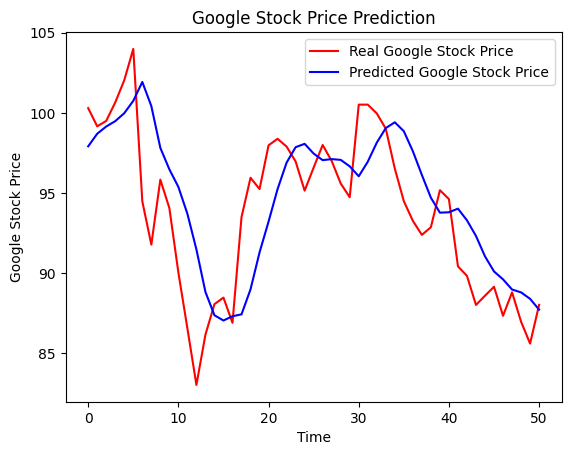

In [10]:
import matplotlib.pyplot as plt

# Plot the predicted vs actual stock prices
plt.plot(Y_test[0], color = 'red', label = 'Real Google Stock Price')
plt.plot(predictions, color = 'blue', label = 'Predicted Google Stock Price')
plt.title('Google Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('Google Stock Price')
plt.legend()
plt.show()